# Summary of this notebook

In the [last notebook](02_extract_images_and_data.ipynb), we exported the downloaded images as individual `.npy` files and the non-image data as a `.csv` file.  In this notebook, we examine the non-image data to make sure that no data are missing and that no other unexpected problems occurred.  We then explore the features in these data.

In [ ]:
#If using Google Colab and Google Drive, run the following commands

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#REPLACE THIS COMMAND WITH THE APPROPRIATE PATH TO THE "code" FOLDER ON YOUR GOOGLE DRIVE
#%cd ./drive/MyDrive/poverty_project/group_project/code

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

#from os import listdir
#from os.path import isfile, join
#pip install geos
#conda install geopandas

In [2]:
combined = pd.read_csv('../data/combined_dhs_data.csv', index_col='index')
combined.head()

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest
index,,,,,,,,
angola_2011_00-0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922,0
angola_2011_00-1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494,0
angola_2011_00-2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085,0
angola_2011_00-3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711,0
angola_2011_00-4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748,0


In [3]:
# Function to convert year to 3 range categories
def year_to_range(year):
    if year < 2011.5:
        return '2009-2011'
    elif year > 2014.5:
        return '2015-2017'
    else:
        return '2012-2014'

In [4]:
# Add column for new feature
combined['year_range'] = combined['year'].map(lambda x: year_to_range(x))
combined.head()

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest,year_range
index,,,,,,,,,
angola_2011_00-0,angola,2011.0,2.595618,1.0,36.0,-12.350257,13.534922,0,2009-2011
angola_2011_00-1,angola,2011.0,2.209620,1.0,32.0,-12.360865,13.551494,0,2009-2011
angola_2011_00-2,angola,2011.0,0.906469,1.0,36.0,-12.613421,13.413085,0,2009-2011
angola_2011_00-3,angola,2011.0,1.105359,1.0,35.0,-12.581454,13.397711,0,2009-2011
angola_2011_00-4,angola,2011.0,1.879344,1.0,37.0,-12.578135,13.418748,0,2009-2011


# Exploratory Data Analysis

### Countries

In [5]:
combined.country.value_counts()

malawi                          1954
kenya                           1830
tanzania                        1583
nigeria                         1439
ethiopia                        1141
rwanda                           984
mozambique                       874
angola                           847
lesotho                          794
burkina_faso                     789
zimbabwe                         784
uganda                           777
benin                            746
zambia                           719
ghana                            607
mali                             590
senegal                          585
cameroon                         532
democratic_republic_of_congo     486
sierra_leone                     435
cote_d_ivoire                    341
togo                             330
guinea                           300
Name: country, dtype: int64

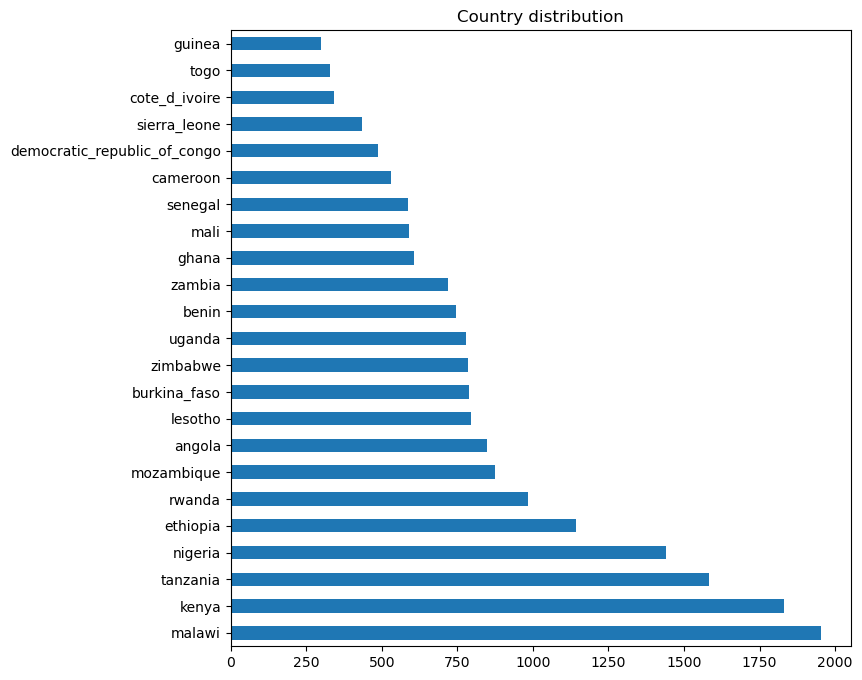

In [6]:
combined.country.value_counts().plot(kind='barh', title='Country distribution', figsize=(8,8));
plt.savefig('../presentation_images/country_distribution')

### Years beginning the 3-year period of observation

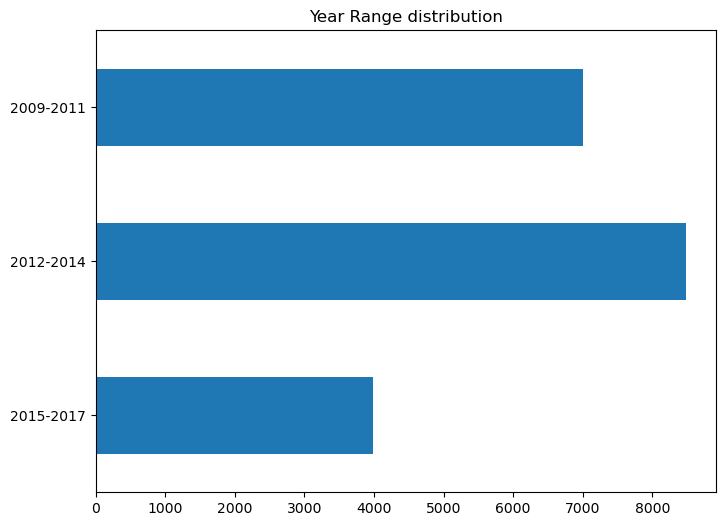

In [7]:
combined.year_range.value_counts().sort_index(ascending=False).plot(kind='barh', title='Year Range distribution', figsize=(8,6));
plt.savefig('../presentation_images/year_range_distribution')

### Welath Indices

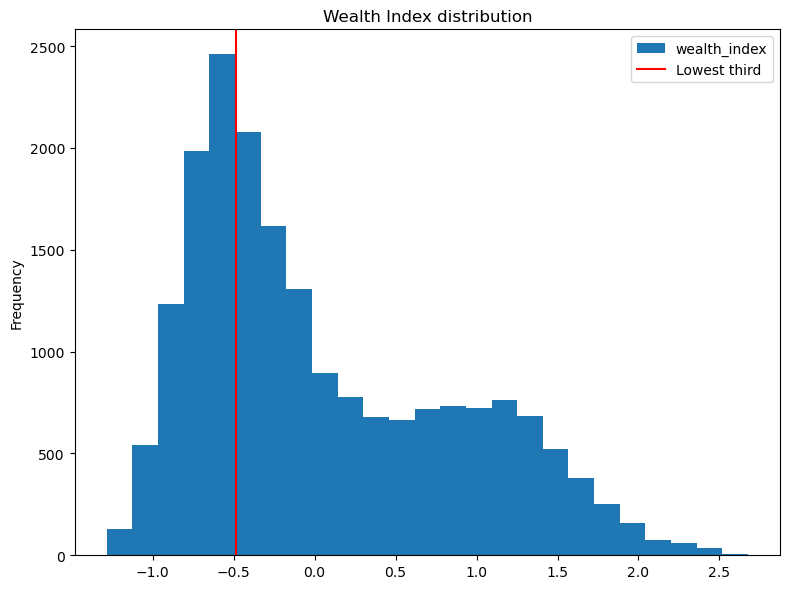

In [8]:
lower_third = combined.wealth_index.quantile(.333)

combined.wealth_index.plot(kind='hist', title='Wealth Index distribution', figsize=(8,6), bins=25)
plt.axvline(x = lower_third, color = 'r', label = 'Lowest third')
plt.legend();
plt.tight_layout();
plt.savefig('../presentation_images/wealth_index_distribution')

In [9]:
combined.wealth_index.describe()

count    19467.000000
mean         0.051598
std          0.806677
min         -1.282605
25%         -0.586443
50%         -0.207042
75%          0.666849
max          2.675832
Name: wealth_index, dtype: float64

In [10]:
combined.wealth_index.median()

-0.2070417255163192

In [11]:
combined.wealth_index.quantile(.333)

-0.48295173960924137

#### So the wealth distribution is skewed to the right.  This is not surprising.

### Urban vs. Non-Urban

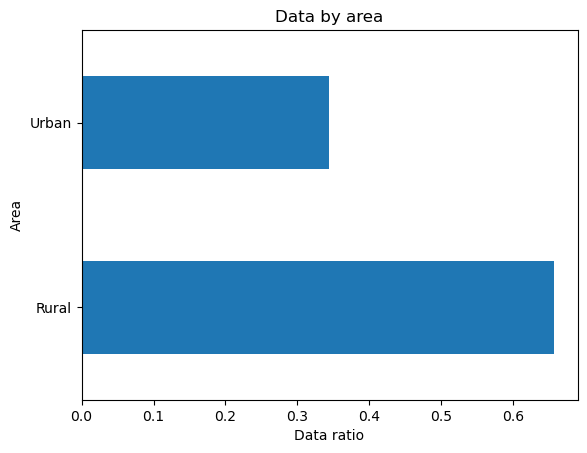

In [12]:
combined.is_urban.value_counts(normalize=True).plot(kind='barh', title='is_urban distribution');
plt.title('Data by area')
plt.xlabel('Data ratio')
plt.ylabel('Area')
plt.yticks([0, 1], ['Rural', 'Urban']);
plt.savefig('../presentation_images/data_by_area')

### Households per Village

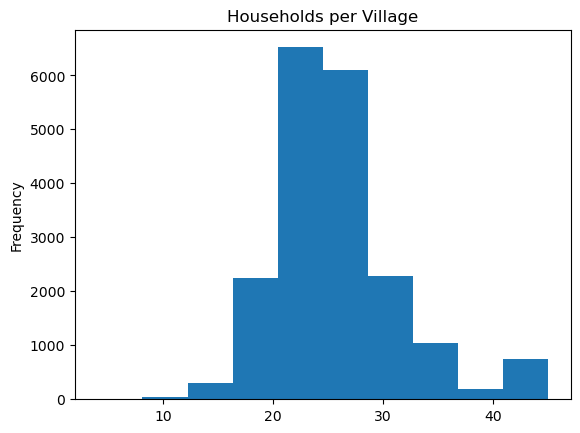

In [13]:
combined.households.plot(kind='hist', title = 'Households per Village');
plt.savefig('../presentation_images/households_per_village')

In [14]:
combined.households.mean()

25.619201725997844

#### The average households is 25.6 households/village.

### Geographic Coordinates

#### - Data density by map

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


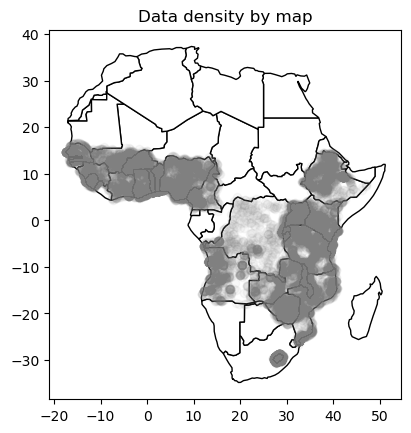

<Figure size 640x480 with 0 Axes>

In [15]:
# Data density by map
gdf = geopandas.GeoDataFrame(combined, geometry=geopandas.points_from_xy(combined.longitude, combined.latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='gray', alpha=0.05)
plt.title('Data density by map')
plt.show();
plt.savefig('../presentation_images/data_density_by_map')
#https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html

#### - Rural/Urban by map

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


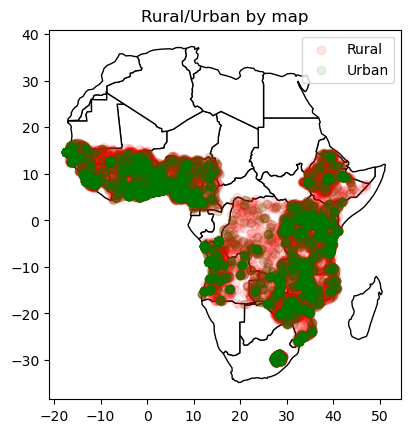

In [16]:
# Coordinates plot
gdf = geopandas.GeoDataFrame(combined, geometry=geopandas.points_from_xy(combined.longitude, combined.latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'Africa'].plot(
    color='white', edgecolor='black')

# Plot all to red
gdf.plot(ax=ax, color='red', alpha=0.1)

# Then plot Urban area to green
gdf = geopandas.GeoDataFrame(combined[combined['is_urban']==1], geometry=geopandas.points_from_xy(combined[combined['is_urban']==1].longitude, combined[combined['is_urban']==1].latitude))
gdf.plot(ax=ax, color='green', alpha=0.1)
plt.title('Rural/Urban by map')
plt.legend(['Rural', 'Urban'])
plt.savefig('../presentation_images/rural_urban_by_map')
plt.show();

### Rural/Urban Wealth index

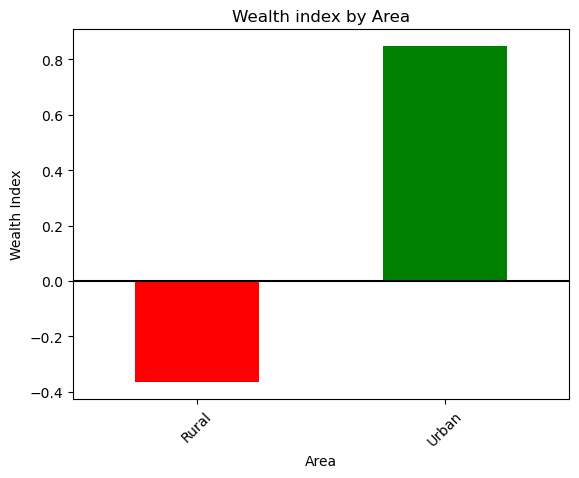

In [17]:
# Bar plot
combined.groupby(by=['is_urban']).mean()['wealth_index'].plot(kind='bar', color=['red', 'green']);
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.title('Wealth index by Area')
plt.xlabel('Area')
plt.ylabel('Wealth Index')
plt.xticks([0, 1], ['Rural', 'Urban'], rotation=45);
plt.savefig('../presentation_images/wealth_index_by_area')